<a href="https://colab.research.google.com/github/lauragoon/Face-Mask-Detector/blob/main/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Reshape
from keras.models import Model
import matplotlib.pyplot as plt

In [3]:
def get_data(batch_size, directory):
  
  datagen = image.ImageDataGenerator()
  dta = datagen.flow_from_directory(directory, class_mode='binary', batch_size=100)

  return dta

In [4]:
def knn(model, output_size):
    vector = np.prod(model.output_shape[1:])
    x = Reshape(target_shape=(vector,))(model.output)
    x = Dense(units=output_size, activation='linear', use_bias=False)(x)             
    knn_model = Model(inputs=[model.input], outputs=x)
    return knn_model

In [5]:
def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=0)
    return vectors / norms

In [12]:
def model_accuracy(k, model, test_batch_images, test_batch_class, train_batch_class):
  prediction = []
  for i in test_batch_images:
      im = np.expand_dims(i, axis=0)
      im = preprocess_input(im)
      result = joined_model.predict([im]).reshape(-1)
      result = result.argsort()[-k:][::-1]
      result_class = []
      for j in result:
          result_class.append(train_batch_class[j])
      sum_result = round(sum(result_class) / k)
      prediction.append(sum_result)

  accuracy = 0
  for i in range(len(test_batch_class)):
    if prediction[i] == test_batch_class[i]:
      accuracy += 1

  return accuracy/len(test_batch_class)

Found 1026 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
finished feature extraction
built model
plot k= 3
plot k= 7
plot k= 11
plot k= 15
plot k= 19


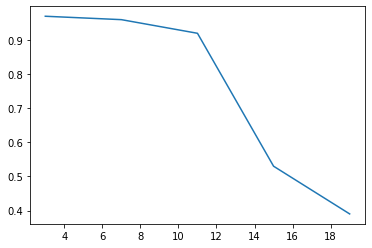

In [15]:
## generate data
train_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset/training'
test_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset/test'

train_data = get_data(100, train_path)
test_data = get_data(50, test_path)

train_batch_images, train_batch_class = train_data.next()
test_batch_images, test_batch_class = test_data.next()

## pre-trained neural network to extract features
nn_model = ResNet50(input_shape=(256,256,3),
                    weights='imagenet',
                    include_top=False,
                    pooling='avg')

## feature extraction
img_features = nn_model.predict(train_batch_images).T

print('finished feature extraction')

## create knn model
joined_model = knn(nn_model, img_features.shape[1])

## normalize features
norm_img_features = normalize_vectors(img_features)

## set model weights
weights = joined_model.get_weights()
weights[-1] = norm_img_features
joined_model.set_weights(weights)

print('built model')

## graph k vs accuracy
x = [4*i+3 for i in range(5)]
y = []

for k in x:
  y.append(model_accuracy(k, joined_model, test_batch_images, test_batch_class, train_batch_class))
  print('plot k=', k)

plt.plot(x,y)


In [16]:
## choose k=3
y

[0.97, 0.96, 0.92, 0.53, 0.39]

In [8]:
## references: https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c, https://github.com/sorenlind/keras-knn/blob/master/keras-knn.ipynb, 